why we using python 2.7


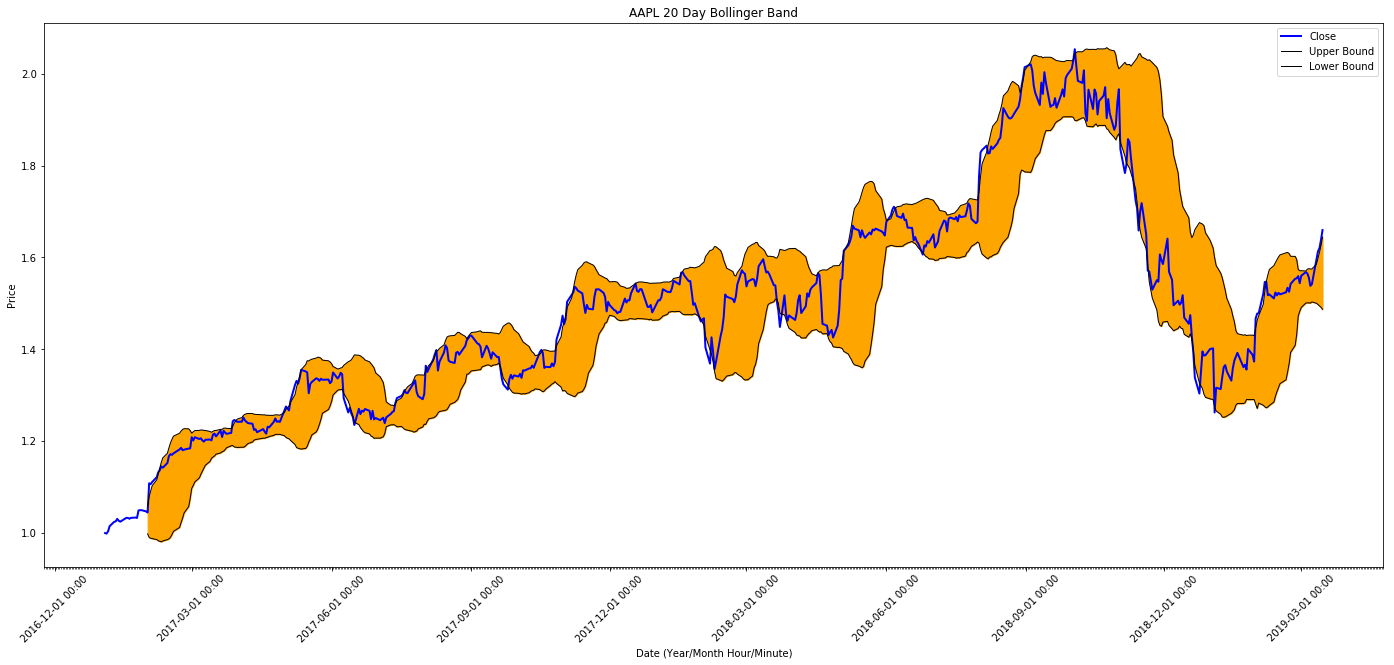

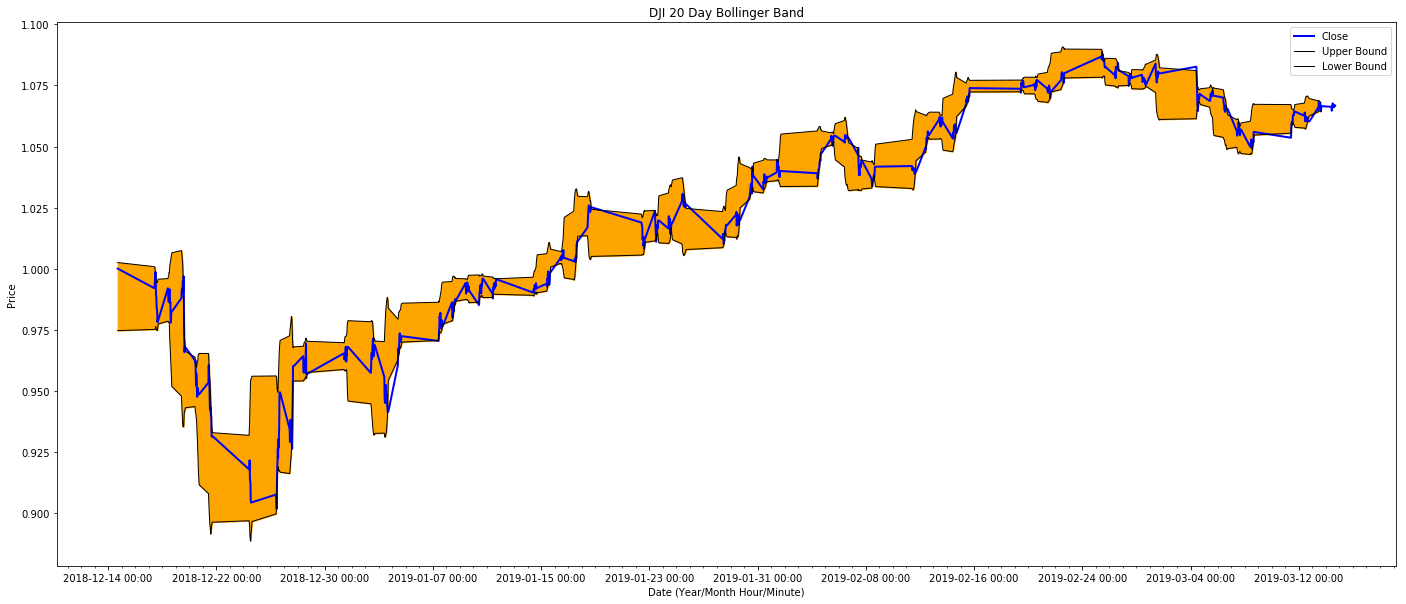

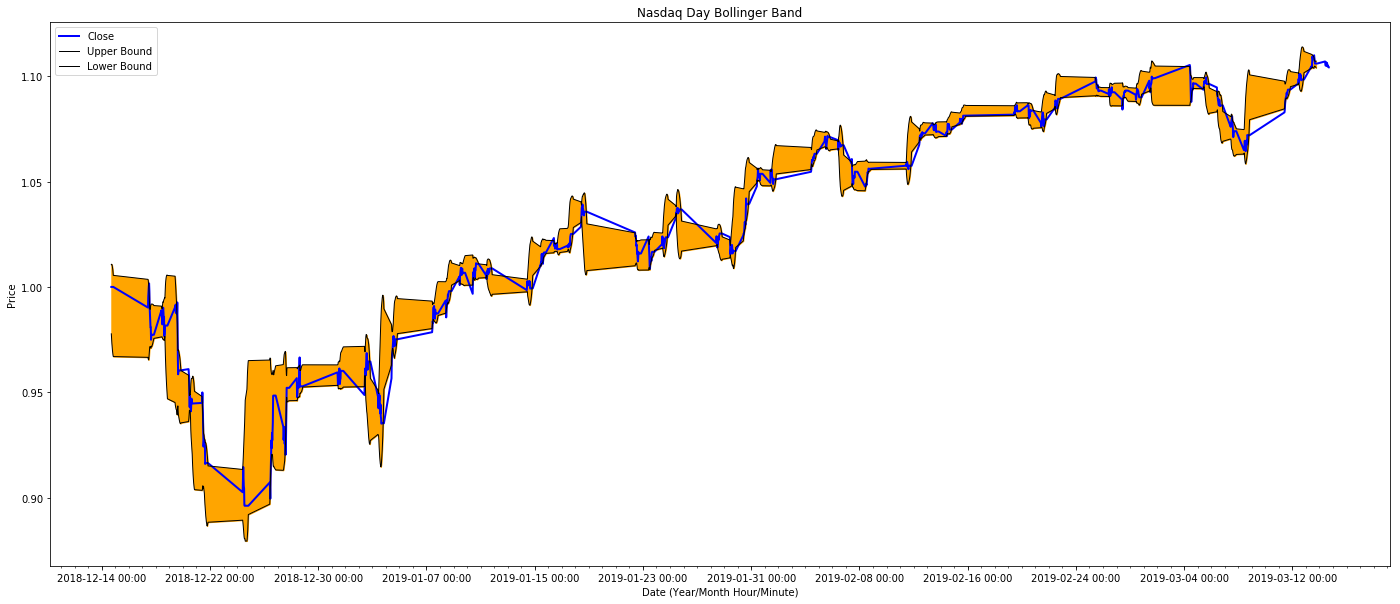

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as matdates
import matplotlib as mpl
% matplotlib inline
def Sma_Ema():
    print "hello sma ema"
    
def RSI():
    print "hello rsi"
    
def Bollinger(df):
    #section reference: https://medium.com/python-data/setting-up-a-bollinger-band-with-python-28941e2fa300
    df['20days'] = df['Close'].rolling(window=20).mean()
    df['20std'] = df['Close'].rolling(window=20).std()
    df['Upper Bound'] = df['20days'] + (df['20std'] * 2)
    df['Lower Bound'] = df['20days'] - (df['20std'] * 2)
    #https://stackoverflow.com/a/50907336 plot three column base on date
    #df.plot(x='Date',y=['Close','Upper Band', 'Lower Band'])
    #plt.show()
    return df
    
def BollingerPlot(df,pltname):
    # set style, empty figure and axes
    #plt.style.use('fivethirtyeight')
    fig = plt.figure(figsize=(24,10)) #
    ax = fig.add_subplot(111)
    
    
    #--------set up ticker----
    #https://stackoverflow.com/a/37219987 reference of the code
    Daylocator = matdates.DayLocator(interval =8)
    #locator documentation https://matplotlib.org/1.3.1/api/dates_api.html
    Daylocator2 =matdates.DayLocator(interval =1)
    Daylocator.MAXTICKS  = 400000
    majorFmt = matdates.DateFormatter('%Y-%m-%d %H:%M')   
    ax.xaxis.set_minor_locator(Daylocator2)
    ax.xaxis.set_major_locator(Daylocator)
    ax.xaxis.set_major_formatter(majorFmt)
    plt.setp(ax.xaxis.get_majorticklabels(),rotation = 90)
    #plt.xticks(rotation=90)
    #---------------------------
    
    # set x-axis as date from dataframe index
    #https://stackoverflow.com/a/41114772 set an select an index from df
    df= df.set_index('Date')
    x_axis=df.index.get_level_values('Date')
    
    # Plot shaded 21 Day Bollinger Band 
    ax.fill_between(x_axis, df['Upper Bound'], df['Lower Bound'], color='orange')

    # Plot Adjust Closing Price 
    ax.plot(x_axis, df['Close'], color='blue', lw=2)
    ax.plot(x_axis, df['Upper Bound'], color='Black', lw=1)
    ax.plot(x_axis, df['Lower Bound'], color='Black', lw=1)
    # Set Title & Show the Image
    ax.set_title(pltname)
    ax.set_xlabel('Date (Year/Month Hour/Minute)')
    ax.set_ylabel('Price')
    ax.legend()
    plt.show();

    ''' two interesting differences
    # Print out country column as Pandas Series
    print(cars['cars_per_cap'])

    # Print out country column as Pandas DataFrame
    print(cars[['cars_per_cap']])
    
    another tutorial on plotting time series:
    https://stackoverflow.com/a/4091264
    '''
    
def AAPLBollingerPlot(df,pltname):
    fig = plt.figure(figsize=(24,10)) #
    ax = fig.add_subplot(111)
    #ticker
    majorFmt = matdates.DateFormatter('%Y-%m-%d %H:%M')  
    Daylocator2 =matdates.DayLocator(interval =1)
    ax.xaxis.set_minor_locator(Daylocator2)
    ax.xaxis.set_major_formatter(majorFmt)
    plt.setp(ax.xaxis.get_majorticklabels(),rotation = 45)
    
    df= df.set_index('Date')
    x_axis=df.index.get_level_values('Date')
    
    ax.fill_between(x_axis, df['Upper Bound'], df['Lower Bound'], color='orange')
    ax.plot(x_axis, df['Close'], color='blue', lw=2)
    ax.plot(x_axis, df['Upper Bound'], color='Black', lw=1)
    ax.plot(x_axis, df['Lower Bound'], color='Black', lw=1)
    ax.set_title(pltname)
    ax.set_xlabel('Date (Year/Month Hour/Minute)')
    ax.set_ylabel('Price')
    ax.legend()
    plt.show();
    
#three dataframes are called DJIdata,NASDAQ30data and AAPLdata     
#---------------------------------------------------
def load_data(s):
    data = pd.read_csv("{}.csv".format(s))
    #change string into date format
    data['Date']= pd.to_datetime(data['Date'], format="%Y/%m/%d %H:%M:%S")
    return data
def normalize(dfdata):
    #divide last element in df series
    day1= float(dfdata['Close'].iloc[[-1]])
    #div function https://stackoverflow.com/a/43675057
    dfdata['Close']=dfdata['Close'].div(day1)
    return dfdata

#appl data has different order than the other two
def aaplnormalize(dfdata):
    #divide last element in df series
    day1= float(dfdata['Close'].iloc[[0]])
    #div function https://stackoverflow.com/a/43675057
    dfdata['Close']=dfdata['Close'].div(day1)
    return dfdata

if __name__== "__main__":
    print "why we using python 2.7"
    #-----------Data Input-------------------
    s = 'DJI30'
    DJIdata = load_data(s)
    DJIdata=normalize(DJIdata)
    
    s = 'NASDAQ30'
    NASDAQ30data = load_data(s)
    NASDAQ30data=normalize(NASDAQ30data)
    
    s = 'AAPL'
    AAPLdata = load_data(s)
    AAPLdata=aaplnormalize(AAPLdata)
    #----------------------------------------
    AAPLdata=Bollinger(AAPLdata)
    AAPLBollingerPlot(AAPLdata, 'AAPL 20 Day Bollinger Band')
    
    DJIdata=Bollinger(DJIdata)
    BollingerPlot(DJIdata, 'DJI 20 Day Bollinger Band')
    
    NASDAQ30data=Bollinger(NASDAQ30data)
    BollingerPlot(NASDAQ30data, 'Nasdaq Day Bollinger Band')
    

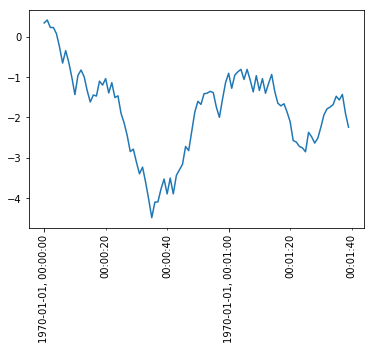

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as matdates

N = 100

fig, ax = plt.subplots()
x = np.arange(N).astype('<i8').view('M8[s]').tolist()
y = (np.random.random(N)-0.5).cumsum()
ax.plot(x, y)


seclocator = matdates.SecondLocator(bysecond=[20, 40]) 
minlocator = matdates.MinuteLocator(byminute=range(60))  # range(60) is the default

seclocator.MAXTICKS  = 40000
minlocator.MAXTICKS  = 40000

majorFmt = matdates.DateFormatter('%Y-%m-%d, %H:%M:%S')  
minorFmt = matdates.DateFormatter('%H:%M:%S')  

ax.xaxis.set_major_locator(minlocator)
ax.xaxis.set_major_formatter(majorFmt)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)

ax.xaxis.set_minor_locator(seclocator)
ax.xaxis.set_minor_formatter(minorFmt)
plt.setp(ax.xaxis.get_minorticklabels(), rotation=90)

#plt.subplots_adjust(bottom=0.5)
plt.show()